In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import dask
from datetime import datetime

### prepare the co2 file

In [16]:
f = '/glade/scratch/djk2120/trendy2023/co2/global_co2_ann_1700_2022.txt'
df=pd.read_csv(f,header=None,sep='  ')

/glade/work/djk2120/miniconda3/envs/trendy-py/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [18]:
df

,0,1
0,1700,276.59
1,1701,276.62
2,1702,276.65
3,1703,276.67
4,1704,276.70
...,...,...
318,2018,406.94
319,2019,409.63
320,2020,412.10
321,2021,414.26


In [24]:
co2=df[1].values[1:]
yrs=df[0].values[1:]

In [53]:
ds0

<xarray.Dataset>
Dimensions:    (lat: 1, lon: 1, nv: 4, time: 321, bounds: 2)
Coordinates:
  * time       (time) float64 181.0 546.0 911.0 ... 1.163e+05 1.166e+05 1.17e+05
  * lat        (lat) float64 0.0
  * lon        (lon) float64 180.0
Dimensions without coordinates: nv, bounds
Data variables:
    lonc       (lat, lon) float64 180.0
    latc       (lat, lon) float64 0.0
    lonv       (lat, lon, nv) float64 0.0 360.0 360.0 0.0
    latv       (lat, lon, nv) float64 90.0 -90.0 -90.0 90.0
    mask       (lat, lon) float64 1.0
    frac       (lat, lon) float64 1.0
    area       (lat, lon) float64 12.57
    CO2        (time, lat, lon) float32 276.6 276.6 276.7 ... 409.6 412.1 414.3
    time_bnds  (time, bounds) float32 9.969e+36 9.969e+36 ... 9.969e+36
    date       (time) float64 1.75e+07 1.751e+07 ... 1.75e+07 1.751e+07
Attributes:
    history:        08/31/2022 15:25: convert by trendy2022_prep.ipynb
    creation_date:  08/31/2022 15:25
    source:         converted from TRENDYs global_co2_ann_1700_2021.txt
    creator:        Daniel Kennedy, djk2120@ucar.edu

In [10]:
#using last year as template:
f='/glade/campaign/asp/djk2120/TRENDY2022/forcing/co2/fco2_datm_global_simyr_1701-2021_TRENDY_c220831.nc'
ds0=xr.open_dataset(f,decode_times=False)

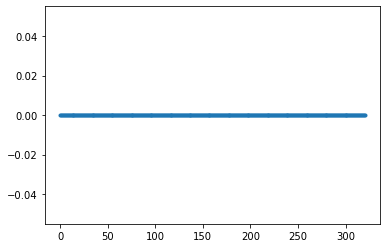

In [31]:
days_since_jan1701=(yrs-1700)*365-184
plt.plot(days_since_jan1701[:-1]-ds0.time.values,'.')

In [59]:
ds1['CO2']=xr.DataArray(co2[:,np.newaxis,np.newaxis],dims=ds0.CO2.dims)
ds1['time']=xr.DataArray(days_since_jan1701,dims='time')
ds1['CO2'].attrs=ds0.CO2.attrs
ds1['time'].attrs=ds0.time.attrs


In [60]:
dvs=[v for v in ds0.data_vars]
for v in dvs:
    if 'time' not in ds0[v].dims:
        ds1[v]=ds0[v]

In [37]:
f = '/glade/p/cgd/tss/people/dll/TRENDY2020_Forcing/fco2_datm_global_simyr_1750-2014_CMIP6_c180929.nc'
ds1 = xr.open_dataset(f,decode_times=False).isel(time=np.arange(320)<319)  #removing 1700
ds1.time.attrs['units']='days since 1701-01-01'

In [65]:
date = datetime.now().strftime("%m/%d/%Y %H:%M")
hist_str = date+': convert by trendy2023_prep.ipynb'
ds1.attrs={'history':hist_str,'creation_date':date,
              'source':'converted from '+f,
              'creator':'Daniel Kennedy, djk2120@ucar.edu'}

In [67]:
fout='/glade/scratch/djk2120/trendy2023/co2/fco2_datm_global_simyr_1701-2022_TRENDY_c230821.nc'
ds1.to_netcdf(fout)

### edit the ndep files
 - I reused NDEP from last year
 - here's my conversion code


In [28]:
f = glob.glob('/glade/scratch/djk2120/trendy2022/ndep/*.nc')
ds2 = xr.open_mfdataset(f,combine='nested',decode_times=False,parallel=True,chunks={'time':12})

In [7]:
f = '/glade/p/cgd/tss/people/dll/TRENDY2019_Forcing/Ndep/TRENDY2019_Ndep_Monthly_c190821.nc'
ds = xr.open_dataset(f)

In [30]:
ndep = xr.Dataset()
clm_names = ['dry_deposition_NHx_as_N','dry_deposition_NOy_as_N','wet_deposition_NHx_as_N','wet_deposition_NOy_as_N']
trn_names = ['drynhx','drynoy','wetnhx','wetnoy']

for clm,trn in zip(clm_names,trn_names):
    ndep[clm]=ds2[trn].copy(deep=True)
    

In [31]:
noy = 'NDEP_NOy_month'
ndep[noy] = 1000*(ds2.drynoy+ds2.wetnoy).copy(deep=True)
ndep[noy].attrs = ds[noy].attrs

nhx = 'NDEP_NHx_month'
ndep[nhx] = 1000*(ds2.drynhx+ds2.wetnhx).copy(deep=True)
ndep[nhx].attrs = ds[nhx].attrs

ntot = 'NDEP_month'
ndep[ntot] = ndep[noy]+ndep[nhx]
ndep[ntot].attrs = ds[ntot].attrs
ndep['time']=ds['time'].copy(deep=True)

In [33]:
thedir = '/glade/scratch/djk2120/trendy2022/ndep/'
nfile  = thedir+'TRENDY2022_Ndep_Monthly_c220802.nc'
ndep['dry_deposition_NHx_as_N'].to_netcdf(nfile)

In [34]:
appends = list(ndep.data_vars)
appends.remove('dry_deposition_NHx_as_N')
for thisvar in appends:
    print(thisvar)
    ndep[thisvar].to_netcdf(nfile,'a')

dry_deposition_NOy_as_N
wet_deposition_NHx_as_N
wet_deposition_NOy_as_N
NDEP_NOy_month
NDEP_NHx_month
NDEP_month


In [144]:
da = ds.datesec.copy(deep=True)
da[:]=0
ndep['datesec'] = da.copy(deep=True)

In [145]:
ndep['date']=ds['date'].copy(deep=True)

In [149]:
gw = np.cos(ndep.lat/360*2*np.pi)
gw = 2*gw/gw.sum()
ndep['gw'] = xr.DataArray(gw,dims='lat')

In [162]:
appends = ['date','datesec','gw']
for thisvar in appends:
    print(thisvar)
    ndep[thisvar].to_netcdf(nfile,'a')

date
datesec
gw
